# `CleanSamples` model

In [1]:
# srun --nodes=1 --ntasks=1 --cpus-per-task=24 --mem=100g --time=04:00:00 --pty bash -i
# Sconda conda activate  tensorflow2; cd /mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/results/cross_validation_allsamples; python


In [2]:
%load_ext lab_black

In [3]:
import json
import re
import matplotlib.pyplot as plt
import sys
import os
import pkg_resources
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
)
from tensorflow.keras.initializers import GlorotUniform

from tensorflow.keras.optimizers import Adam
from keras import backend as K

from keras.models import model_from_json

/scratch/ipykernel_193547/4183228157.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


## Declare some constants

In [4]:
cross_validations_auc_rocs = []
cross_validations_f1s = []
chrom_order = []
# categories, layers
categories = 1  # Total labels: set to 1 if binary.
layers = [230, 200, 100, 50, 1]

# output figures:
fig_out_dir = "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/results/cross_validation_allsamples/keras_models_figures"
model_out_dir = "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/results/cross_validation_allsamples/model_per_chr/"
file_path = os.path.join(
    fig_out_dir, "FILTERED_cross_validation_all_scores_per_sample_per_chrom.tsv"
)

In [67]:
fig_out_dir = "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/results/cross_validation_allsamples/keras_models_figures"
model_out_dir = "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/results/cross_validation_allsamples/model_per_chr/"
file_path = os.path.join(
    model_out_dir, "FILTERED_cross_validation_all_scores_per_sample_per_chrom.tsv"
)
file_path

'/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/results/cross_validation_allsamples/model_per_chr/FILTERED_cross_validation_all_scores_per_sample_per_chrom.tsv'

### Loading Datasets

In [54]:
x_all_data = np.load(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_x.npy"
).T
y_all_data = np.load(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_y.npy"
).reshape(-1, 1)
m_all_data = pd.read_parquet(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_m.parquet"
)

print(
    f"""
X all data shape:\t{x_all_data.shape}
Y all data shape:\t{y_all_data.shape}
Meta data shape:\t{m_all_data.shape}
"""
)


X all data shape:	(1063153, 230)
Y all data shape:	(1063153, 1)
Meta data shape:	(1063153, 6)



### Function to get the proper chr data

In [6]:
def subset_dataset(m_all_data, chr_masks, chrom_genes_count, chrom):
    # Use pre-calculated boolean masks
    train_idx = m_all_data[chr_masks["train"][chrom]].index
    test_idx = m_all_data[chr_masks["testing"][chrom]].index
    dev_idx = m_all_data[chr_masks["dev"][chrom]].index
    genes_in_test_chrom = chrom_genes_count[chrom]

    # Subset training
    x_train = x_all_data[train_idx, :]
    y_train = y_all_data[train_idx, :]
    # Subset test
    x_test = x_all_data[test_idx, :]
    y_test = y_all_data[test_idx, :]
    # Subset dev
    x_dev = x_all_data[dev_idx, :]
    y_dev = y_all_data[dev_idx, :]
    # reshape
    return x_train, x_test, x_dev, y_train, y_test, y_dev, genes_in_test_chrom

In [53]:
# NOTE: Delete

# m_all_data.head()
# chrom_genes_count
# test_idx = m_all_data[chr_masks["testing"]["chr4"]].index
# m_all_data.chr.value_counts()
# n_samples = m_all_data.groupby("gene").size().mean().astype(int)

# Pre-calculate genes per chrom
# m_all_data.groupby("chr")["gene"].count() // n_samples
# x_train, x_test, x_dev, y_train, y_test, y_dev, genes_in_test_chrom = subset_dataset(
#     m_all_data, chr_masks, chrom_genes_count, "chr4"
# )
# assert all(
#     [
#         True if a == b else False
#         for a, b in zip(m_all_data.loc[test_idx, "binary_category"], y_test)
#     ]
# )
y_test

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]])

### Funciton to remove layer that is causing issues:

In [7]:
# Load the original JSON data
def json_remove_input_layer(json_file):
    # Read json
    with open(json_file, "r") as file:
        data = json.load(file)
        file.close()
    # Check if it has the problem and delete
    if (
        data["config"]["layers"]
        and data["config"]["layers"][0]["class_name"] == "InputLayer"
    ):
        del data["config"]["layers"][0]
        print("deleted 'InputLayer' layer config")

    # Save the modified data back to a new JSON file
    with open(json_file, "w") as file:
        json.dump(data, file, indent=4)
        file.close()


# Remove the first layer from the 'layers' list within the 'config' key

In [8]:
# Subest 10 chromosomes:
unique_chromosomes = m_all_data["chr"].unique()
unique_chromosomes = unique_chromosomes[
    (unique_chromosomes != "chrY") & (unique_chromosomes != "chrX")
]
output_layer = "sigmoid"

# Pre-calculate number of samples composing dataset
n_samples = m_all_data.groupby("gene").size().mean().astype(int)

# Pre-calculate genes per chrom
chrom_genes_count = m_all_data.groupby("chr")["gene"].count() // n_samples

# Pre-calculate boolean masks for each chromosome to avoid repetitive indexing
chr_masks = {"testing": {}, "dev": {}, "train": {}}
chr_test_dev = {}
for i, chrom in enumerate(unique_chromosomes):
    # Find the next chromosome in the list, wrapping around to the first if at the end
    next_chrom = unique_chromosomes[(i + 1) % len(unique_chromosomes)]
    chr_test_dev[chrom] = next_chrom
    # build dict of dict of masks per test chrom
    chr_masks["testing"][chrom] = m_all_data["chr"] == chrom
    chr_masks["dev"][chrom] = m_all_data["chr"] == next_chrom
    chr_masks["train"][chrom] = ~(
        (m_all_data["chr"] == chrom) | (m_all_data["chr"] == next_chrom)
    )

# output_dict_file = os.path.join(model_out_dir, "chr_excluded_for_test_and_dev.json")
# with open(output_dict_file, "w") as f:
#     json.dump(chr_test_dev, f)

In [9]:
# Make this a function to get a cleaner code:
def make_keras_model(X):
    keras_model = Sequential()
    keras_model.add(
        Dense(
            200,
            activation="relu",
            name="1",
            input_dim=X.shape[1],
            kernel_initializer=GlorotUniform(),
        )
    )
    keras_model.add(Dropout(0.15))
    keras_model.add(
        Dense(100, activation="relu", name="2", kernel_initializer=GlorotUniform())
    )
    keras_model.add(Dropout(0.15))
    keras_model.add(
        Dense(50, activation="relu", name="3", kernel_initializer=GlorotUniform())
    )
    keras_model.add(
        Dense(
            1, activation="sigmoid", name="Output", kernel_initializer=GlorotUniform()
        )
    )
    keras_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return keras_model

In [10]:
def test_and_auc(keras_model, X, Y, n_samples, n_test_genes, chrom):
    results = []
    for i in range(n_samples):
        start_index = i * n_test_genes
        end_index = start_index + n_test_genes
        # Slicing the arrays to get the current chunk
        X_sub = X[start_index:end_index, :]
        Y_sub = Y[start_index:end_index]
        preds = keras_model.evaluate(x=X_sub, y=Y_sub)
        ProbableValues = keras_model.predict(X_sub)
        Obs = pd.Series(Y_sub.flatten().astype(int))
        Pred = pd.Series(ProbableValues.round().flatten().astype(int))
        auc_roc = roc_auc_score(Obs, Pred)
        results.append((chrom, f"sample_{i}", round(auc_roc, 4), round(preds[1], 4)))

    return results

### Train Model

In [11]:
unique_chromosomes[1:]

array(['chr5', 'chr7', 'chr12', 'chr11', 'chr10', 'chr19', 'chr3', 'chr8',
       'chr1', 'chr2', 'chr17', 'chr9', 'chr14', 'chr6', 'chr15', 'chr13',
       'chr18', 'chr16'], dtype=object)

In [72]:
# results = []
for chrom in unique_chromosomes[0:1]:
    K.clear_session()
    # Declare outputs
    output_model_configs = os.path.join(model_out_dir, "keras_model_" + chrom + ".json")
    output_model_weights = os.path.join(model_out_dir, "keras_model_" + chrom + ".h5")

    # Subset the x and y datasets using the obtained indices
    X, x_test, x_dev, Y, y_test, y_dev, n_test_genes = subset_dataset(
        m_all_data, chr_masks, chrom_genes_count, chrom
    )

    # define the keras model
    clean_data_model = make_keras_model(X)
    clean_data_model.fit(x=X, y=Y, batch_size=1024, epochs=60)
    preds = clean_data_model.evaluate(x=x_dev, y=y_dev)

    # serialize model to JSON
    model_json = clean_data_model.to_json()
    with open(output_model_configs, "w") as json_file:
        json_file.write(model_json)
        json_file.close()
    # Load back for formatting
    json_remove_input_layer(output_model_configs)
    # serialize weights to HDF5
    clean_data_model.save_weights(output_model_weights)

    results.append(
        test_and_auc(clean_data_model, x_test, y_test, n_samples, n_test_genes, chrom)
    )

Epoch 1/60
912/912 [==============================] - 5s 4ms/step - loss: 0.6395 - accuracy: 0.6844
Epoch 2/60
912/912 [==============================] - 4s 4ms/step - loss: 0.5087 - accuracy: 0.7548
Epoch 3/60
912/912 [==============================] - 4s 4ms/step - loss: 0.4973 - accuracy: 0.7615
Epoch 4/60
912/912 [==============================] - 4s 4ms/step - loss: 0.4911 - accuracy: 0.7657
Epoch 5/60
912/912 [==============================] - 4s 4ms/step - loss: 0.4873 - accuracy: 0.7684
Epoch 6/60
912/912 [==============================] - 4s 4ms/step - loss: 0.4838 - accuracy: 0.7708
Epoch 7/60
912/912 [==============================] - 4s 4ms/step - loss: 0.4810 - accuracy: 0.7727
Epoch 8/60
912/912 [==============================] - 4s 4ms/step - loss: 0.4797 - accuracy: 0.7737
Epoch 9/60
912/912 [==============================] - 4s 4ms/step - loss: 0.4776 - accuracy: 0.7739
Epoch 10/60
912/912 [==============================] - 4s 4ms/step - loss: 0.4756 - accuracy: 0.7760

In [73]:
flat_results = [item for sublist in results for item in sublist]
flat_results = pd.DataFrame(
    flat_results, columns=["chr", "sample", "auroc", "accuracy"]
)
flat_results.to_csv(file_path, index=False)

In [74]:
file_path

'/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/results/cross_validation_allsamples/model_per_chr/FILTERED_cross_validation_all_scores_per_sample_per_chrom.tsv'

# Make plots

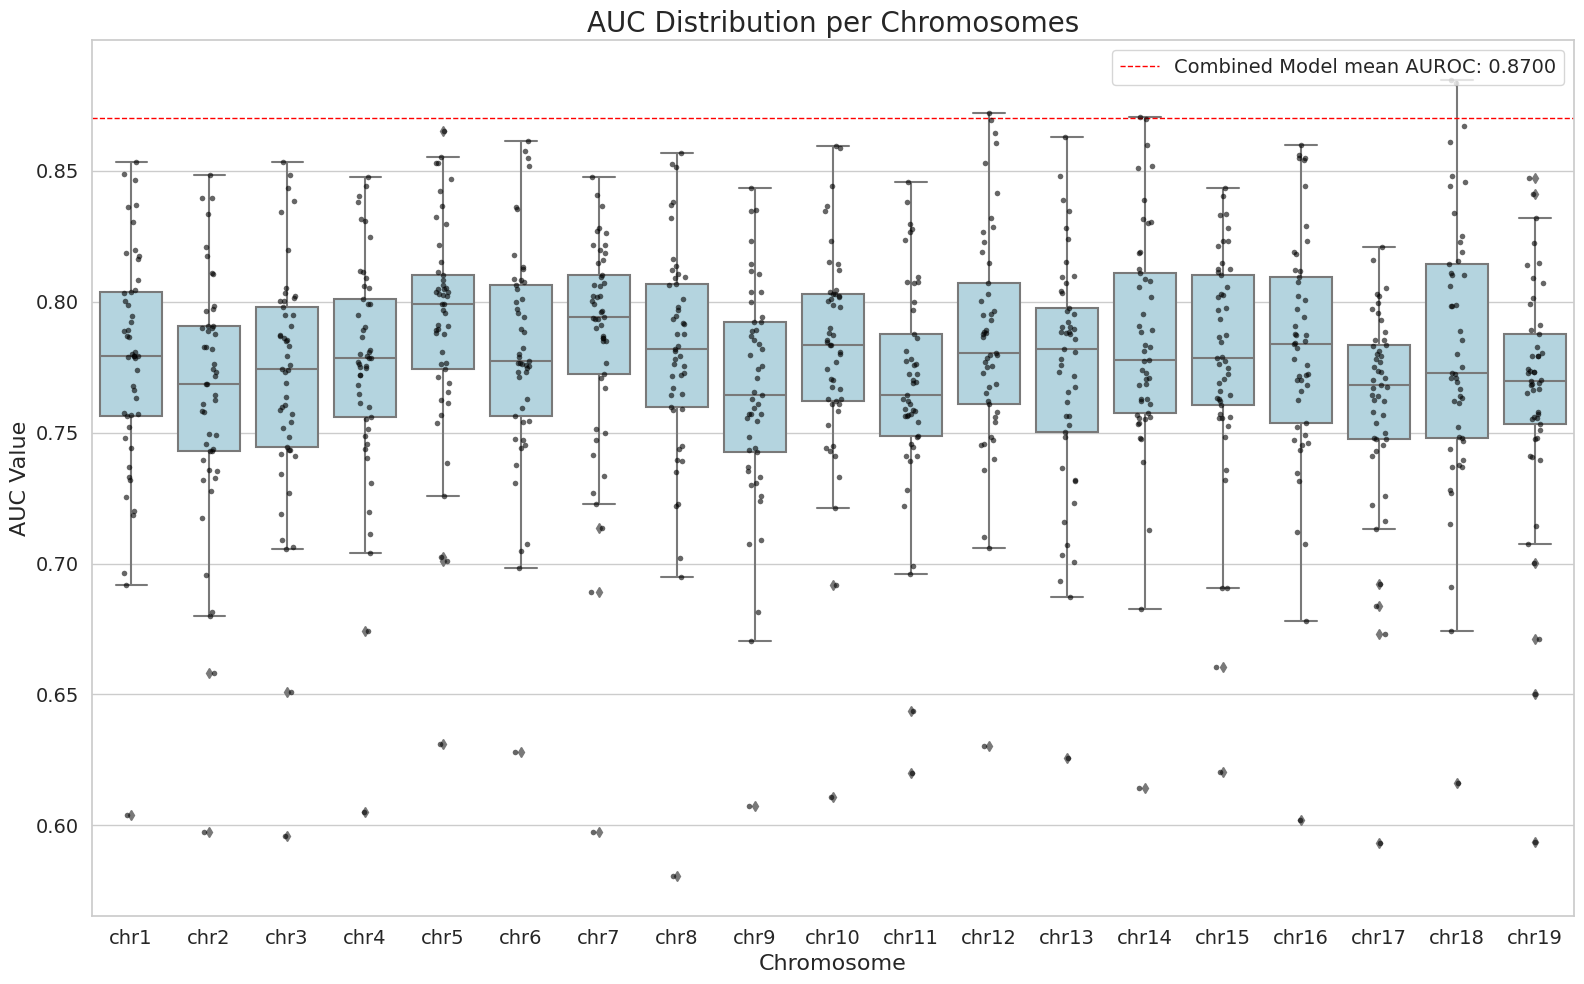

In [77]:
# Load the CSV file into a DataFrame
auc_data = pd.read_csv(file_path)
mean_auc_score = 0.87


# Re-defining the sort function with the 're' module imported
def sort_chromosomes(chromosomes):
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(chromosomes, key=alphanum_key)


# Applying the custom sort function to the chromosome names again
sorted_chromosomes = sort_chromosomes(auc_data["chr"].unique())

# Now, creating the boxplot chromosome-wise
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")

# Creating the boxplot with chromosomes sorted correctly
sns.stripplot(
    x="chr",
    y="auroc",
    data=auc_data,
    color="black",
    order=sorted_chromosomes,
    size=4,
    jitter=True,
    alpha=0.6,
)
ax = sns.boxplot(
    x="chr",
    y="auroc",
    data=auc_data,
    color="lightblue",
    order=sorted_chromosomes,
)

# Adding black points for each data point on top of the boxplots

# Adding a red line for the mean AUC score
plt.axhline(
    mean_auc_score,
    color="red",
    linestyle="--",
    linewidth=1,
    label=f"Combined Model mean AUROC: {mean_auc_score:.4f}",
)

# Adding a legend
plt.legend(loc="upper right", fontsize=14, frameon=True)

# Customizing the plot
ax.set_title("AUC Distribution per Chromosomes", fontsize=20)
ax.set_xlabel("Chromosome", fontsize=16)
ax.set_ylabel("AUC Value", fontsize=16)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

plt.tight_layout()

# Save the figure with the mean AUC line
output_sample_boxplot_path = os.path.join(
    fig_out_dir,
    "FILTERED_cross_validation_auc_distribution_per_chrom_boxplot_overlayed",
)
# plt.savefig(output_sample_boxplot_path + ".png", dpi=300, bbox_inches="tight")
# plt.savefig(output_sample_boxplot_path + ".pdf", dpi=150, bbox_inches="tight")

# Show the plot
plt.show()
plt.close()